# Model Building
Summary:    
- I up sample the positive case (the sign-up rate is only 3.9% in the data set.)
- I used logistic regression model and achieved 0.9907 auc score and 98.5% accuracy. From model coefficient, I find users are satisfied with website data analysis service, retention rate service and persona analysis service provided by Sensor because these are the positive factors. However, the introduction video and about page need to be better as watching video or reading about page is a negative factor. It means users feel disappointed after watching the video from website or reading the about page.
- I used Gradient Boosting Decision Tree model to make improvement. The important features given by GBDT also show big influence in Logistic Regression model. However, I can't tell the influence direction from feature importance. So I think I will choose Logistic Regression model for this case.

In [10]:
import pandas as pd
import numpy as np

#### Sample train and test data set.

Since the convertion rate is around 3%, it is necessary to do up-sampling for positive samples (converted users). 

In [13]:
data_engineered = pd.read_csv('sensor_data_engineered.csv', sep='\t')
all_positive_data = data_engineered[data_engineered['isSuccess'] == 1]
all_negative_data = data_engineered[data_engineered['isSuccess'] == 0]
print('The size of positive data set is: %s.' % (all_positive_data.shape[0]))
print('The size of nagative data set is: %s.' % (all_negative_data.shape[0]))

The size of positive data set is: 457.
The size of nagative data set is: 11251.


In [14]:
from sklearn.model_selection import train_test_split
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(\
    all_positive_data.drop(['distinct_id', 'isSuccess'], axis = 1), all_positive_data[['isSuccess']], test_size=0.2, random_state=1)
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(\
    all_negative_data.drop(['distinct_id', 'isSuccess'], axis = 1), all_negative_data[['isSuccess']], test_size=0.2, random_state=1)

In [15]:
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = pd.DataFrame()
y_test = pd.DataFrame()
for i in range(25):
    X_train = X_train.append([X_train_pos])
    y_train = y_train.append([y_train_pos])
X_train = X_train.append([X_train_neg])
y_train = y_train.append([y_train_neg])
y_train = y_train.values.ravel()
X_test = X_test.append([X_test_pos, X_test_neg])
y_test = y_test.append([y_test_pos, y_test_neg])
y_test = y_test.values.ravel()

#### Define measure functions

In [16]:
def train_test_model(clf, X_train, y_train, X_test, y_test):
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

In [17]:
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [18]:
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of conversion')
    plt.legend(loc="lower right")
    plt.show()

#### Logistic regression

              train      test
metrics                      
AUC        0.997077  0.997064
Accuracy   0.994372  0.985489
Precision  0.988945  0.730159
Recall     1.000000  1.000000
f1-score   0.994442  0.844037


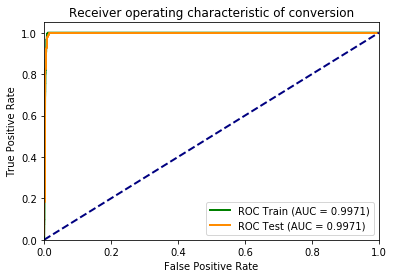

In [19]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
clf_LR = LogisticRegression()
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1.0], 
    'penalty': ['l1', 'l2'],
    'random_state': [1]
}
acc_scorer = make_scorer(roc_auc_score)
grid_obj = GridSearchCV(clf_LR, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
# Set the clf to the best combination of parameters
clf_LR_best = grid_obj.best_estimator_
train_test_model(clf_LR_best, X_train, y_train, X_test, y_test)

In [20]:
def get_top_values(lst, n, labels):
    return [labels[i] for i in np.argsort(lst)[::-1][:n]]

In [21]:
coef_name = np.array(list(X_train.columns))
coef_value = clf_LR_best.coef_[0]
print('The top five importent features are: \n%s' % \
      ','.join(feature for feature in get_top_values(coef_value, 5, coef_name)))

The top five importent features are: 
tot_visits_per_week,cpc_medium,mfeed_medium,web_term,ret_term


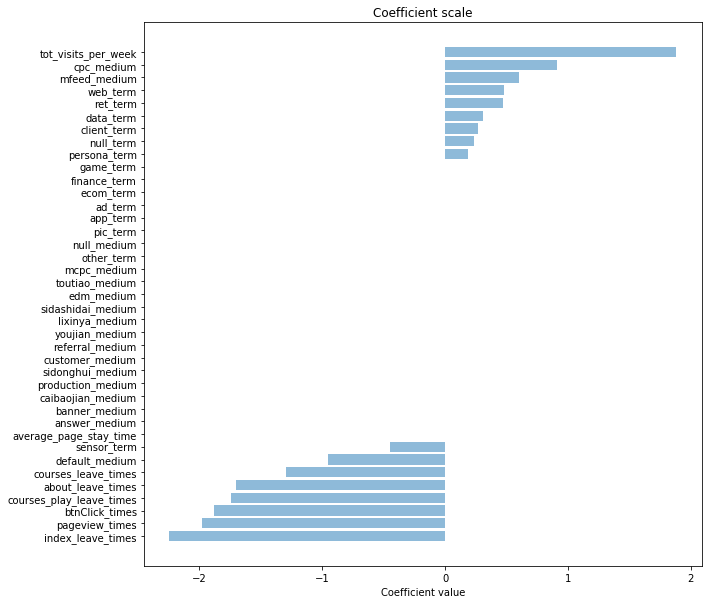

In [22]:
plt.figure(figsize=(10,10))
objects = [coef_name[i] for i in np.argsort(coef_value)[::-1][:]]
y_pos = np.arange(len(objects))
plt.barh(y_pos, np.sort(coef_value)[::-1], align='center', alpha = 0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient value')
plt.title('Coefficient scale')
plt.gca().invert_yaxis()


From the model, I can see that these are the positive factor:    
- total visits per week   
- users from cpc medium   
- users from mfeed medium    
- users find sensor website using query containing '网页/网站'   
- users find sensor website using query containing '留存率'    
- users find sensor website using query containing '数据/分析'   
- users find sensor website using query containing '客户'   
- users find sensor website using query containing '用户图像'   

I can see that these are the negative factor:   
- users find sensor website using query containing '神策'    
- users from default medium   
- courses leave times     
- about leave times    
- courses play leave times    
- button click times     
- pageview times      
- index leave times    

Conclusion: users are satisfied with website data analysis service, retention rate service and persona analysis service provided by Sensor because these are the positive factors. However, the introduction video and about page need to be better as watching video or reading about page is a negative factor. It means users feel disappointed after watching the video from website or reading the about page.

#### Gradient Boosting Decision Tree 

              train      test
metrics                      
AUC        1.000000  0.979236
Accuracy   0.999945  0.980794
Precision  0.999890  0.711712
Recall     1.000000  0.858696
f1-score   0.999945  0.778325


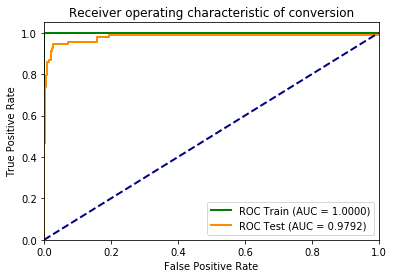

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
clf_GBDT = GradientBoostingClassifier(random_state = 1, subsample = 0.8)
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'max_features': [3,5,7],
}
acc_scorer = make_scorer(roc_auc_score)

grid_obj = GridSearchCV(clf_GBDT, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
# Set the clf to the best combination of parameters
clf_GBDT_best = grid_obj.best_estimator_
train_test_model(clf_GBDT_best, X_train, y_train, X_test, y_test)

In [24]:
feature_name = np.array(list(X_train.columns))
feature_importance = clf_GBDT_best.feature_importances_
print('The top five importent features are: \n%s' % \
      ','.join(feature for feature in get_top_values(feature_importance, 5, feature_name)))

The top five importent features are: 
tot_visits_per_week,pageview_times,average_page_stay_time,btnClick_times,index_leave_times


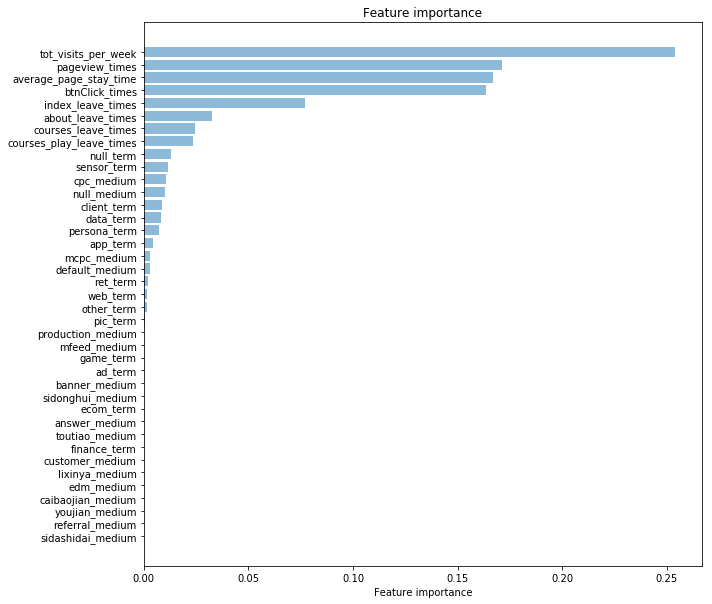

In [25]:
plt.figure(figsize=(10,10))
objects = [feature_name[i] for i in np.argsort(feature_importance)[::-1][:]]
y_pos = np.arange(len(objects))
plt.barh(y_pos, np.sort(feature_importance)[::-1], align='center', alpha = 0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Feature importance')
plt.title('Feature importance')
plt.gca().invert_yaxis()

Overall, I think the GBDT model is consistent with Logistic Regression model. The important features given by GBDT also show big influence in Logistic Regression model. However, I can't tell the influence direction from feature importance. So I think I will choose Logistic Regression model for this case.